In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pylab

colors = [['red', 100.0/3], ['black', 200.0/3]]
colors_effect = {'red': -1, 'black': 1}
other_action = {'hit':'stick', 'stick':'hit'}


class Card:
    def __init__(self, value=0, color=''):
        self.value = value
        self.color = color

def total_prop(items):
    p = 0
    for x, y in items:
        p += y
    return p

def pick_item(items, action=False):   # pick item (i.e. color or action) with a probability
    if action:
        items = sorted(items.items(), key=lambda (x, y): y)
    chosen = np.random.uniform(0, total_prop(items))
    cumulative = 0
    for item, probability in items:
        cumulative += probability
        if cumulative > chosen:
            return item


def draw():  # draw a card
    while True:
        yield Card(np.random.randint(1, 11), pick_item(colors))


def bust(total):
    return not (1 <= total <= 21)


def average(l):
    return float(sum(l))/len(l)

class FewIterationsError(Exception):
    def __str__(self):
        return "Some states have not been visited at all, try increasing the number of iterations"


class Game:
    def __init__(self):
        self.lst_dealer = int()
        self.dealer = int()     # The dealer's sum
        self.player = int()     # The player's sum
        self.visits = {}  # {state: number of times it has been visited}
        self.v_values = {}  # {state s: V(s)}
        self.q_values = {}  # {state s: {action a: Q(s, a)}}
        self.q_values_TD = {}  # {state s: {action a: Q(s, a)}}
        self.q_values_approx = {}  # {state s: {action a: Q(s, a)}}
        self.pi_policy = {}  # {state s: {action a: probability of taking that action from that state}}
        self.visited_states = {}  # visited states in an episode
        self.r_sa = {}  # transition reward {state s: {action a: reward r}}
        self.MSE = []  # Mean-square error for every iteration
        self.drawer = draw()

    def new_game(self):
        self.lst_dealer = np.random.randint(1, 11)
        self.dealer = self.lst_dealer  # The dealer's sum
        self.player = np.random.randint(1, 11)  # The player's sum
        self.visited_states = {}

    @staticmethod
    def hit(card, total):
        return total + card.value * colors_effect[card.color]  # red subtracts, black adds

    def reward(self):
        if bust(self.player) or self.player < self.dealer:
            return -1
        elif bust(self.dealer) or self.player > self.dealer:
            return 1
        else:  # player's sum == dealer's sum
            return 0

    def step(self, a):
        if a == 'hit':  # the player hits
            self.player = self.hit(self.drawer.next(), self.player)
        else:  # the player sticks
            while self.dealer < 17:  # the dealer hits
                self.dealer = self.hit(self.drawer.next(), self.dealer)
                if bust(self.dealer):
                    break
        # return self.reward()

    def state_visits(self, state):
        return sum([y for x, y in self.visits[state].items()])

    def get_eps(self, st, n0=100.0):
        return n0/(n0 + self.state_visits(st))

    def plot_results(self, title="Monte-Carlo"):
        x = xrange(1, 11)  # dealer
        y = xrange(1, 22)  # player
        X, Y = np.meshgrid(x, y)
        Z = np.array([[0. for i in xrange(len(x))] for j in xrange(len(y))])
        for i in x:
            for j in y:
                Z[j - 1][i - 1] = self.v_values[(i, j)]
        fig = pylab.figure()
        ax = Axes3D(fig)
        pylab.title("Optimal value function obtained by "+title)
        ax.set_xlabel("Dealer Showing")
        pylab.xlim([1, 10])
        pylab.xticks(xrange(1, 11))
        ax.set_ylabel("Player Sum")
        pylab.ylim([1, 21])
        pylab.yticks(xrange(1, 22))
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
        plt.figure(figsize=(14,10))
        pylab.show()

    def remember(self, action, Q):
        state = (self.lst_dealer, self.player)
        self.visited_states.setdefault(state, {})
        self.visited_states[state].setdefault(action, [])
        self.visits.setdefault(state, {})
        self.visits[state].setdefault(action, 0)
        self.visits[state][action] += 1
        Q.setdefault(state, {})
        Q[state].setdefault(action, 0)

    def alpha(self, state, action):
        return 1.0 / self.visits[state][action]

    def update_pi_policy(self, s, a, constant=False, eps=0.05):
        self.pi_policy.setdefault(s, {})
        self.pi_policy[s].setdefault(a, 0)
        if constant:
            self.pi_policy[s][a] = (1 - eps + (eps / 2.0)) * 100
        else:
            self.pi_policy[s][a] = (1 - self.get_eps(s) + (self.get_eps(s) / 2.0)) * 100
        self.pi_policy[s][other_action[a]] = 100 - self.pi_policy[s][a]

    def update_policy(self, Q, constant=False, eps=0.05):
        for s in self.visited_states:
            max_q = float('-inf')
            for a in self.visited_states[s]:
                self.pi_policy.setdefault(s, {})
                self.pi_policy[s].setdefault(a, 0)
                q_s_a = Q[s][a]
                if q_s_a > max_q:  # a == a*
                    max_q = q_s_a
                    # |A(s)| = 2
                    if constant:
                        self.pi_policy[s][a] = (1 - eps + (eps / 2.0)) * 100
                    else:
                        self.pi_policy[s][a] = (1 - self.get_eps(s) + (self.get_eps(s) / 2.0)) * 100
                else:
                    if constant:
                        self.pi_policy[s][a] = (eps / 2.0) * 100
                    else:
                        self.pi_policy[s][a] = (self.get_eps(s) / 2.0) * 100
                self.pi_policy[s][other_action[a]] = 100 - self.pi_policy[s][a]

    def monte_carlo(self, iterations=1000):
        self.pi_policy = {}
        self.v_values = {}
        self.q_values = {}
        self.visits = {}
        self.r_sa = {}
        for episode in xrange(iterations):
            self.new_game()
            while not (bust(self.player)):
                state = (self.lst_dealer, self.player)
                self.visits.setdefault(state, {})
                # An alternative way of implementing eps-greedy exploration strategy
                # Convergeance happens after about 200k episodes
#                 eps = self.get_eps(state)
#                 if np.random.uniform() < eps:
#                     action = np.random.choice(['hit', 'stick'])
#                 else:
#                     action = max(self.q_values[state].items(), key= lambda (x,y): y)[0]
                # However, I found that this implementation converges with only about 100k
                try:  # Choose an action (without taking it yet)
                    action = pick_item(self.pi_policy[state], action=True)
                except KeyError:
                    action = np.random.choice(['hit', 'stick'])
                self.remember(action, self.q_values)
                self.step(action)
                if action == 'stick':
                    break
            r = self.reward()
            # for every state visited in last episode
            for s in self.visited_states:  # first-visit Monte-Carlo
                for a in self.visited_states[s]:
                    self.q_values[s][a] += self.alpha(s, a) * \
                                           (r - self.q_values[s][a])
            self.update_policy(self.q_values)
        d = 0
        for s in self.q_values:
            d += len(self.q_values[s])
            self.v_values[s] = max(self.q_values[s].items(), key=lambda (x, y): y)[1]
        # print len(self.v_values)
        if d < 420:
            raise FewIterationsError
        self.plot_results()

    def plot_learning_curve(self, lamda):
        plt.figure(int(lamda)+2, figsize=(14,10))
#         plt.subplot(211+int(lamda))
        plt.plot(xrange(len(self.MSE)), self.MSE)
        plt.title(r'$\mathrm{Learning\ Curve\ with\:}\ \lambda=%g$' %lamda)
        plt.xlabel('Episode number')
        plt.ylabel('MSE')
        # plt.show()

    def update_q(self, lamda, alpha, delta, s_prime=None, a_prime=None, discount=1):
        for s_ in self.visited_states:
            for a_ in self.visited_states[s_]:
                """  We use only one alpha which is for the current pair of s,a we are 
                at and update all previous pairs accordingly"""
                if s_ == s_prime and a_ == a_prime: continue
                self.q_values_TD[s_][a_] += alpha * delta * self.e[(s_, a_)]
                self.e[(s_, a_)] *= lamda * discount

    def temporal_difference(self, lamda=1.0, iterations=1000, discount=1, plot=False):
        self.pi_policy = {}
        self.v_values = {}
        self.q_values_TD = {}
        self.visits = {}
        self.MSE = []
        for episode in xrange(iterations):
            self.e = {}
            self.new_game()
            self.visited_states = {}
            s = (self.lst_dealer, self.player)
            try:  # Choose an action (without taking it yet)
                a = pick_item(self.pi_policy[s], action=True)
            except KeyError:
                a = np.random.choice(['hit', 'stick'])
            self.remember(a, self.q_values_TD)
            while True:
                self.step(a)
                # r = self.reward()
                if a == 'stick' or bust(self.player):
                    r = self.reward()
                    delta = r - self.q_values_TD[s][a]
                    alpha = self.alpha(s, a)
                    self.e.setdefault((s, a), 0)
                    self.e[(s, a)] += 1
                    self.update_q(lamda, alpha, delta)
                    break
                s_prime = (self.lst_dealer, self.player)
                try:  # Choose an action (without taking it yet)
                    a_prime = pick_item(self.pi_policy[s_prime], action=True)
                except KeyError:
                    a_prime = np.random.choice(['hit', 'stick'])
                # update Q(s, a) for all s,a pairs
                self.remember(a_prime, self.q_values_TD)
                # delta = (r + discount * self.q_values_TD[s_prime][a_prime] - self.q_values_TD[s][a])
                # R = 0 as long as this is not a terminal state, otherwise MSE will go much higher
                # That is just for this game though, since we shouldn't collect any reward if the player neither went
                # bust nor stopped hitting
                delta = (0 + discount * self.q_values_TD[s_prime][a_prime] - self.q_values_TD[s][a])
                alpha = self.alpha(s, a)
                self.e.setdefault((s, a), 0)
                self.e[(s, a)] += 1
                self.update_q(lamda, alpha, delta, s_prime, a_prime)
                a = a_prime
                s = s_prime
                self.update_policy(self.q_values_TD)
            if len(self.q_values) > 0:  # if Monte-Carlo has been run
                mse = 0.0
                d = 0.0
                for s in self.q_values_TD:
                    for a in self.q_values_TD[s]:
                        mse += (self.q_values_TD[s][a] - self.q_values[s][a]) ** 2
                        d += 1
                mse /= d
                self.MSE.append(mse)
        d = 0
        for s in self.q_values_TD:
            d += len(self.q_values_TD[s])
            self.v_values[s] = max(self.q_values_TD[s].items(), key=lambda (x, y): y)[1]
        # print len(self.v_values)
        if len(self.v_values) < 210:
            raise FewIterationsError
        if plot:
            # self.plot_results("TD")
            self.plot_learning_curve(lamda)
        return mse

    # Linear approximation
    def dealer_(self, d=None):
        if d is None:
            d = self.dealer
        return np.where(np.array([(1 <= d <= 4),
                                  (4 <= d <= 7),
                                  (7 <= d <= 10)]))[0]

    def player_(self, p=None):
        if p is None:
            p = self.player
        return np.where(np.array([(1 <= p <= 6),
                                  (4 <= p <= 9),
                                  (7 <= p <= 12),
                                  (10 <= p <= 15),
                                  (13 <= p <= 18),
                                  (16 <= p <= 21)]))[0]

    def phi(self, a, s=None):
        if s is None:
            dealer, player = (self.dealer_(), self.player_())
        else:
            dealer, player = s
        cuboid = np.zeros((3, 6, 2), dtype=np.int)
        for d in dealer:
            for p in player:
                cuboid[d, p, a] = 1
        return cuboid.flatten()
    
    def approx_sarsa2(self, lamda=1.0, iterations=1000, discount=1, plot=False, eps=0.05):
        self.q_values_approx = {}
        alpha = .01  # constant step size
        theta = np.random.randn(36) * 0.1
        actions = ['hit', 'stick']
        self.pi_policy = {}
        self.v_values = {}
        self.visits = {}
        self.MSE = []
        for episode in xrange(iterations):
            e = np.zeros(36)
            self.new_game()
            self.visited_states = {}
            s = (self.lst_dealer, self.player)
            if np.random.uniform() < eps:
                a = np.random.choice(2)
            else:
                a = np.argmax([np.dot(self.phi(0).transpose(), theta), np.dot(self.phi(1).transpose(), theta)])
            while True:
                phi = self.phi(a).transpose()
                self.step(actions[a])
                # r = self.reward()
                if a == 'stick' or bust(self.player):
                    r = self.reward()
                    e += phi
                    delta = r - np.dot(phi, theta)
                    theta += alpha * delta * e
                    break
                s_prime = (self.lst_dealer, self.player)
                # update Q(s, a) for all s,a pairs
                # delta = (r + discount * self.q_values_TD[s_prime][a_prime] - self.q_values_TD[s][a])
                # R = 0 as long as this is not a terminal state, otherwise MSE will go much higher
                # That is just for this game though, since we shouldn't collect any reward if the player neither went
                # bust nor stopped hitting
                Q = np.array([np.dot(self.phi(a).transpose(), theta) for a in range(2)])
                if np.random.uniform() < eps:
                    a_prime = np.random.choice(2)
                else:
                    a_prime = np.argmax(Q)
                delta = (0 + discount * Q[a_prime] - np.dot(phi, theta))
                e = discount * lamda * (e + phi)
                a = a_prime
                s = s_prime
            if len(self.q_values) > 0:  # if Monte-Carlo has been run
                mse = 0.0
                d = 0.0
                for d in xrange(1, 11):
                    for p in xrange(1, 22):
                        for a in xrange(2):
                            self.dealer = d
                            self.player = p
                            phi = self.phi(a).transpose()
                            q = np.dot(phi, theta)
                            self.q_values_approx.setdefault((d, p), {})
                            self.q_values_approx[(d, p)][actions[a]] = q
                            if d == 11:
                                continue
                            mse += np.square(q - self.q_values[(d, p)][actions[a]])
                            d += 1
                mse /= d
                self.MSE.append(mse)
        if plot:
#             self.plot_results("LF")
            self.plot_learning_curve(lamda)
        return mse

    def approx_sarsa(self, lamda=1.0, iterations=1000, discount=1, plot=False, eps=0.05):
        self.q_values_approx = {}
        alpha = .01  # constant step size
        theta = np.random.randn(36) * 0.1
        actions = ['hit', 'stick']
        self.pi_policy = {}
        self.v_values = {}
        self.visits = {}
        self.MSE = []
        for episode in xrange(iterations):
            self.e = {}
            self.new_game()
            self.visited_states = {}
            s = (self.lst_dealer, self.player)
            try:  # Choose an action (without taking it yet)
                a = pick_item(self.pi_policy[s], action=True)
            except KeyError:
                a = np.random.choice(['hit', 'stick'])
            self.remember(a, self.q_values_approx)
            while True:
                self.step(a)
                # r = self.reward()
                if a == 'stick' or bust(self.player):
                    r = self.reward()
                    q_s_a = np.dot(self.phi(actions.index(a), (self.dealer_(s[0]), self.player_(s[1]))).transpose(), theta)
#                     q_s_a = np.dot(self.phi(actions.index(a), (self.dealer_(s[0]), self.player_(s[1]))), theta)
                    self.q_values_approx[s][a] = q_s_a
                    delta = r - q_s_a
                    self.e.setdefault((s, a), 0)
                    self.e[(s, a)] += 1
                    self.update_q(lamda, alpha, delta)
                    break
                s_prime = (self.lst_dealer, self.player)
                try:  # Choose an action (without taking it yet)
                    a_prime = pick_item(self.pi_policy[s_prime], action=True)
                except KeyError:
                    a_prime = np.random.choice(['hit', 'stick'])
                # update Q(s, a) for all s,a pairs
                self.remember(a_prime, self.q_values_approx)
                self.q_values_approx[s_prime][a_prime] = np.dot(self.phi(actions.index(a_prime)).transpose(), theta)
                # delta = (r + discount * self.q_values_TD[s_prime][a_prime] - self.q_values_TD[s][a])
                # R = 0 as long as this is not a terminal state, otherwise MSE will go much higher
                # That is just for this game though, since we shouldn't collect any reward if the player neither went
                # bust nor stopped hitting
                delta = (0 + discount * self.q_values_approx[s_prime][a_prime] - self.q_values_approx[s][a])
                self.e.setdefault((s, a), 0)
                self.e[(s, a)] += 1
                self.update_q(lamda, alpha, delta, s_prime, a_prime)
                a = a_prime
                s = s_prime
                self.update_policy(self.q_values_approx)
            if len(self.q_values) > 0:  # if Monte-Carlo has been run
                mse = 0.0
                d = 0.0
                for s in self.q_values_approx:
                    for a in self.q_values_approx[s]:
                        mse += (self.q_values_approx[s][a] - self.q_values[s][a]) ** 2
                        d += 1
                mse /= d
                self.MSE.append(mse)
        d = 0
        for s in self.q_values_approx:
            d += len(self.q_values_approx[s])
            self.v_values[s] = max(self.q_values_approx[s].items(), key=lambda (x, y): y)[1]
        # print len(self.v_values)
        if len(self.v_values) < 210:
            raise FewIterationsError
        if plot:
            self.plot_results("LF")
            self.plot_learning_curve(lamda)
        return mse


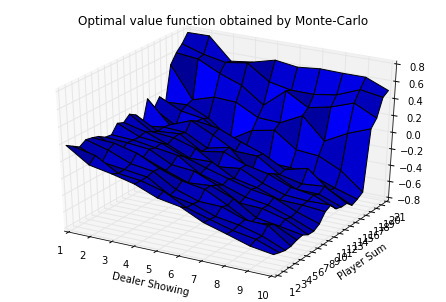

{'hit': 53, 'stick': 40}


In [2]:
game = Game()
game.monte_carlo(100000)
print game.visits[(1, 21)]
plt.figure(figsize=(14,10))
plt.show()

Lambda is: 0	MSE: 0.03058
Lambda is: 0.1	MSE: 0.0272489
Lambda is: 0.2	MSE: 0.0251556
Lambda is: 0.3	MSE: 0.0288712
Lambda is: 0.4	MSE: 0.0273314
Lambda is: 0.5	MSE: 0.0318246
Lambda is: 0.6	MSE: 0.0370075
Lambda is: 0.7	MSE: 0.0462315
Lambda is: 0.8	MSE: 0.0506809
Lambda is: 0.9	MSE: 0.0583751
Lambda is: 1	MSE: 0.0576938


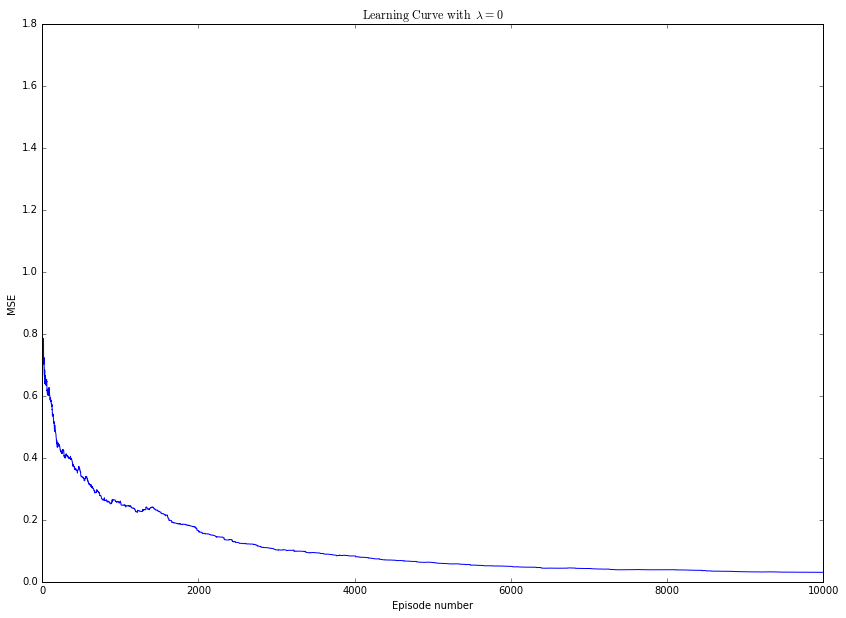

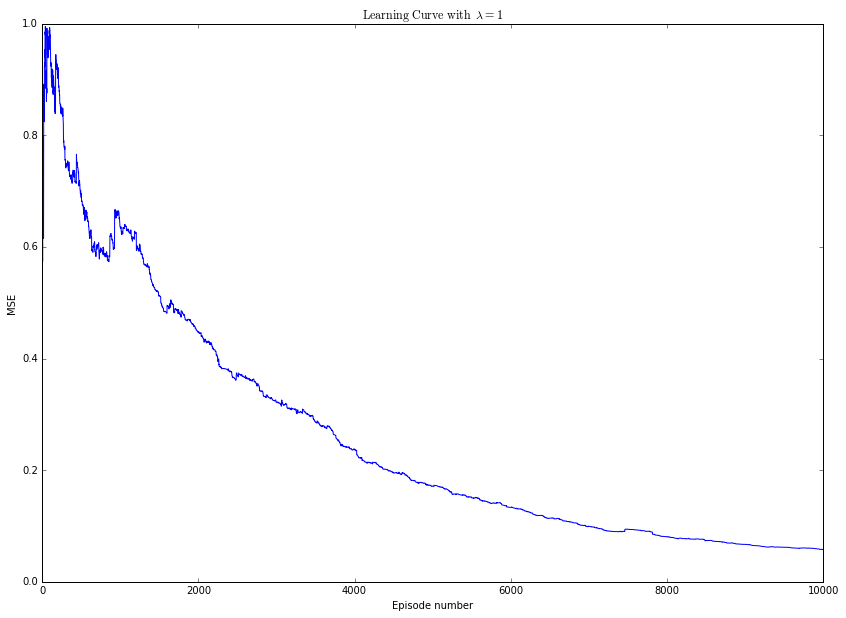

In [3]:
lamdas = []
plots = {}
for i in xrange(11):
    l = i / 10.0
    lamdas.append(l)
    plots[l] = False
plots[0.0] = True
plots[1.0] = True
mses = []
for x in lamdas:
    # 1000 episodes are too few to cover all states, let alone state, action pairs
    mse = game.temporal_difference(lamda=x, iterations=10000, plot=plots[x])
    mses.append(mse)
    print "Lambda is: %g\tMSE: %g" % (x, mse)

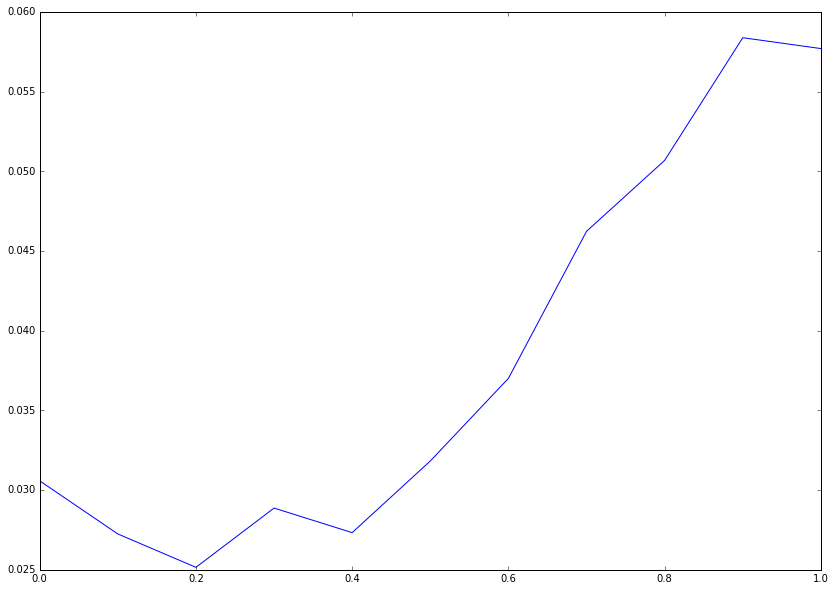

In [4]:
plt.figure(figsize=(14,10))
plt.plot(lamdas, mses)
plt.show()

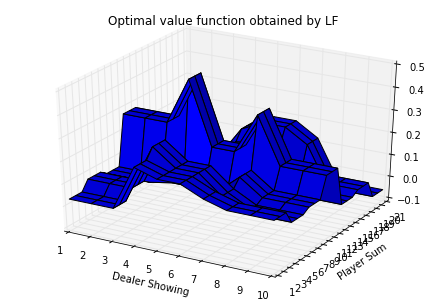

Lambda is: 0	MSE: 0.228535
Lambda is: 0.1	MSE: 0.233052
Lambda is: 0.2	MSE: 0.20863
Lambda is: 0.3	MSE: 0.18941
Lambda is: 0.4	MSE: 0.178551
Lambda is: 0.5	MSE: 0.161985
Lambda is: 0.6	MSE: 0.21514
Lambda is: 0.7	MSE: 0.229983
Lambda is: 0.8	MSE: 0.239794
Lambda is: 0.9	MSE: 0.247518


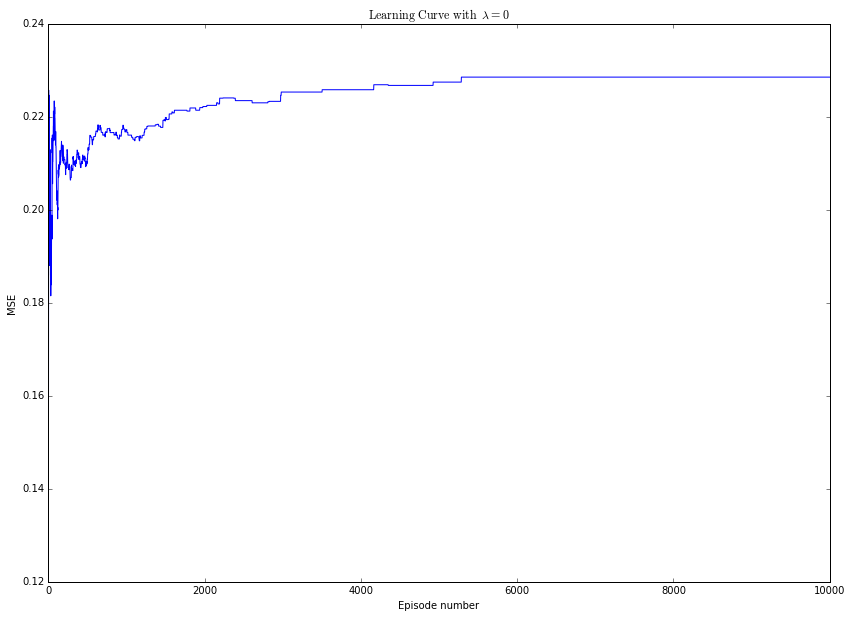

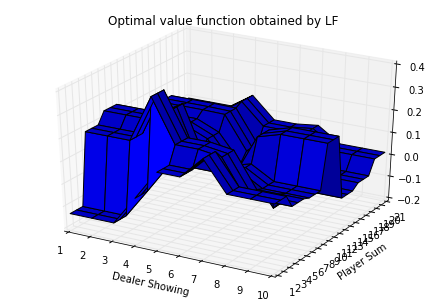

Lambda is: 1	MSE: 0.225932


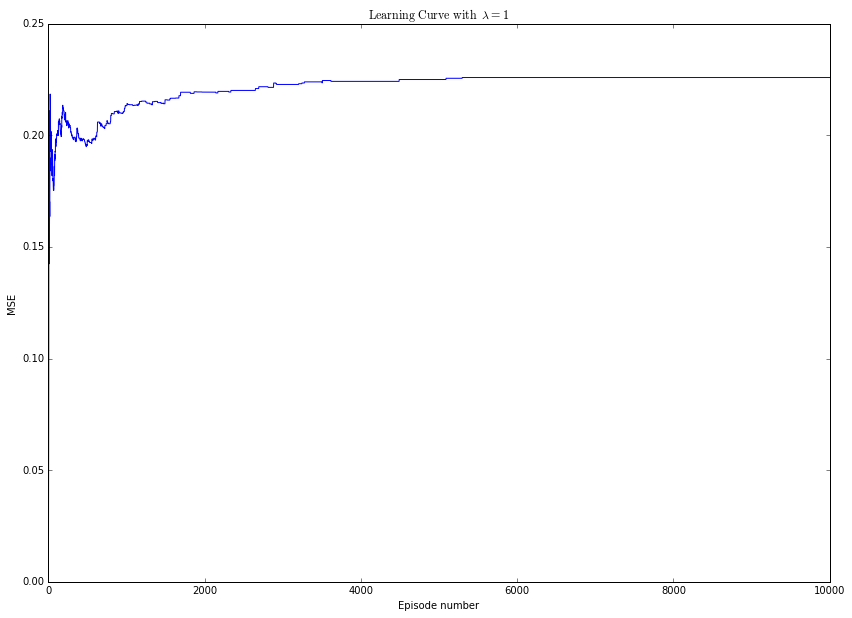

In [5]:
lamdas = []
plots = {}
for i in xrange(11):
    l = i / 10.0
    lamdas.append(l)
    plots[l] = False
plots[0.0] = True
plots[1.0] = True
mses = []
for x in lamdas:
    # 1000 episodes are too few to cover all states, let alone state, action pairs
    plt.figure(figsize=(14,10))
    mse = game.approx_sarsa(lamda=x, iterations=10000, plot=plots[x])
    mses.append(mse)
    print "Lambda is: %g\tMSE: %g" % (x, mse)

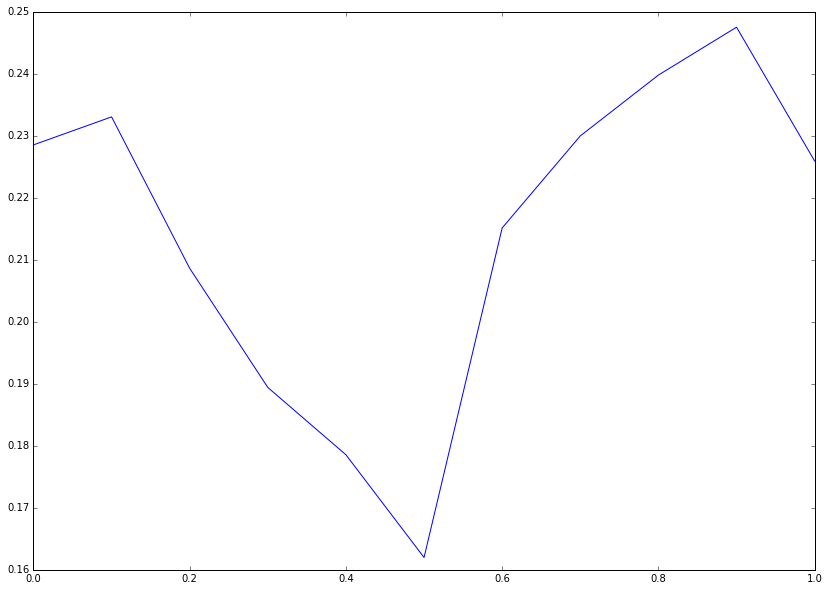

In [6]:
plt.figure(figsize=(14,10))
plt.plot(lamdas, mses)
plt.show()

Lambda is: 0	MSE: 0.999823
Lambda is: 0.1	MSE: 0.462788
Lambda is: 0.2	MSE: 1.09041
Lambda is: 0.3	MSE: 1.47003
Lambda is: 0.4	MSE: 1.61723
Lambda is: 0.5	MSE: 1.92463
Lambda is: 0.6	MSE: 2.4358
Lambda is: 0.7	MSE: 3.20372
Lambda is: 0.8	MSE: 5.75622
Lambda is: 0.9	MSE: 10.32
Lambda is: 1	MSE: 18.7547


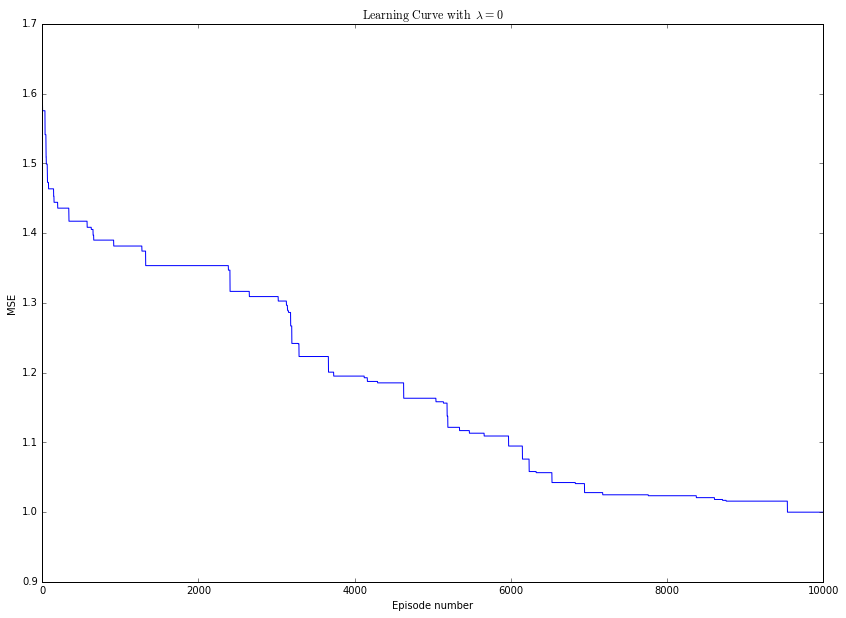

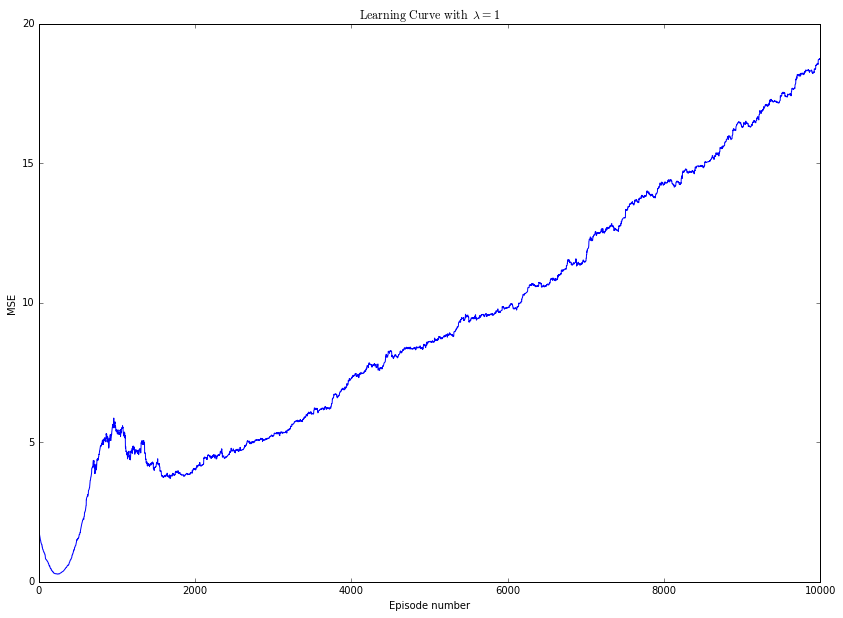

In [7]:
# A different implementation for linear funciton approximation with sarsa lambda
lamdas = []
plots = {}
for i in xrange(11):
    l = i / 10.0
    lamdas.append(l)
    plots[l] = False
plots[0.0] = True
plots[1.0] = True
mses = []
for x in lamdas:
    # 1000 episodes are too few to cover all states, let alone state, action pairs
    mse = game.approx_sarsa2(lamda=x, iterations=10000, plot=plots[x])
    mses.append(mse)
    print "Lambda is: %g\tMSE: %g" % (x, mse)

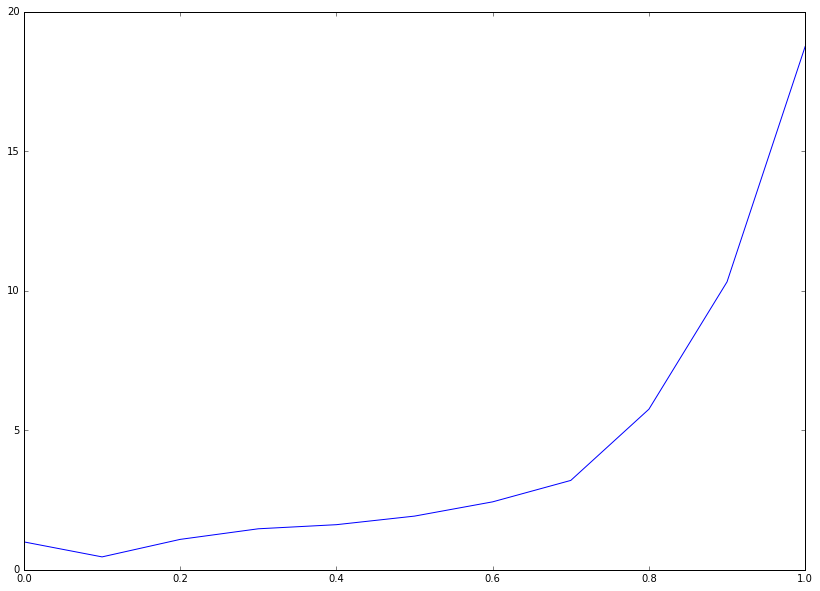

In [8]:
plt.figure(figsize=(14,10))
plt.plot(lamdas, mses)
plt.show()

In [9]:
%%HTML
<h1>What are the pros and cons of bootstrap?</h1>
<p>Bootstraping might increase the runtime of the episode since it requires more computations. It also has less variance than MC, since it depends not on a sample from a start state to an end state, but rather on the current reward and states close to the current one. MC on the other hand is guranteed to converge with better accuracy given enough samples (i.e iterations), while bootstraping has the potential to converge with less iterations. In short, Bootstraping is good to infer predictions from a sample, while MC is better in getting better results for the sample itself.</p>

<h1>Would you expect bootstrapping to help more in blackjack or Easy21?</h1>
<p>In Easy21 even if the player gets total sum of 21, s/he can still hit and get a red card which will get him back from a decicive win. Therefore, bootstraping might work better than in blackjack due to the fact that episodes can be longer (in fact they can go forever! i.e. the player keeps hitting and getting one black card and the next is a red one resetting his total sum), since it will consider this scenario. In MC though, a single episode might take too long while in fact it is not contributing much to the model.</p>

<h1>What are the pros and cons of function approximation in Easy21?</h1>
<p>Linear function approximation bundles overlapping states which results in a significant reduction in the space state and thus the space complexity and the learning time of the simulation. However, some variables are lost and thus some accuracy too. It is also worth mentioning that LF is not guranteed to converge.</p>

<h1>How would you modify the function approximator suggested in this section to get better results in Easy21?</h1>
<p>The overlapping cuboid intervals lead to bad results, since some states would trigger multiple features whose sum may be out of the actual reward limits (i.e. 0 < reward < 1), not to mention that those overlapping intervals don't introduce significant improvement in the model.</p>